## Goodreads Book Recommender

#### Introduction

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### Contents

[Part 0: Preprocessing](#part-0-preprocessing)
- [0.1 - Load and Prepare Data](#01---load-and-prepare-data)
- [0.1 - Write Functions to Process Recommendations](#02---write-functions-to-process-recommendations)

[Part 1: Collaborative Filtering Based on Reader Similarity with KNN](#part-1---collaborative-filtering-based-on-reader-similarity-with-knn)
- [1.1 - Find Similar Readers](#11---find-similar-readers)
- [1.2 - Generate Recommendations](#12---generate-recommendations)


[Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization](#part-2---collaborative-filtering-based-on-predicted-ratings-with-matrix-factorization)
- [2.1 - Factorize User-Rating Matrix with SVD](#21---factorize-user-rating-matrix-with-svd)
- [2.2 - Generate Recommendations by Predicting Ratings](#22---generate-recommendations-by-predicting-ratings)
- [2.3 - Matrix Factorization with Gradient Descent](#23-matrix-factorization-with-gradient-descent)

## Part 0: Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [30]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres, how="left", on="book_id")

# Filter out kids books
df_books = df_books[df_books.loc[:,"children":"comic"].sum(axis=1) < 2]

In [3]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [4]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# Reformat to fit sparse matrix
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="left", on="book_id", suffixes=["_mb","_dfb"]
            )
my_books_id_match = my_books_1[~my_books_1["title_dfb"].isna()]
print(f"Matching on book_id: {my_books_id_match.shape[0]}")

my_books_2 = pd.merge(
    my_books_1[my_books_1["title_dfb"].isna()], df_books[["book_id", "title"]], 
    how="left", left_on="title_mb", right_on="title", suffixes=["_mb","_dfb"]
    )
my_books_match_on_title = my_books_2[~my_books_2["title"].isna()]
print(f"Matching on title: {my_books_match_on_title.shape[0]}")

my_books_id_match = my_books_id_match[["book_id", "rating", "title_dfb"]]\
                        .rename(columns={"title_dfb":"title"})
my_books_match_on_title = my_books_match_on_title[["book_id_dfb", "rating", "title"]]\
                        .rename(columns={"book_id_dfb":"book_id"})

my_books_3 = pd.concat([my_books_id_match, my_books_match_on_title])
my_books_3 = my_books_3.drop_duplicates(subset="book_id")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers for KNN
norm = Normalizer()
df_reviews_norm = norm.fit_transform(df_reviews) 

Target reader ratings: 168
Matching on book_id: 28
Matching on title: 68
Total matches: 96, 57.14% of total


In [5]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [6]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([2-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    regex3 = r"Volume ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [7]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=400, n_recs=15, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [8]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [9]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):

    # Get genre rankings for target and neighbors
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})
    target_genre_ranking = target_genre_ranking.div(target_genre_ranking.sum(axis=0), axis=1)

    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"neighbor"})
    neighbor_genre_ranking = neighbor_genre_ranking.div(neighbor_genre_ranking.sum(axis=0), axis=1)

    genre_rankings = pd.merge(
            target_genre_ranking, neighbor_genre_ranking, left_index=True, right_index=True
            ).reset_index()

    # Plot target genre pref
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='target',
        s=150,
        edgecolors='black',
        linewidths = 0.75,
        label='Target Reader',
        zorder=2,
        )

    # Plot neighbors genre pref
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='neighbor',
        label='Similar Readers',
        s=150,
        zorder=3
        )

    # Iterate through each genre and plot line connecting 2 points
    for ind in list(genre_rankings['index']):
    
        # Plot line connecting points
        plt.plot([genre_rankings[genre_rankings['index']==ind]['target'],
                    genre_rankings[genre_rankings['index']==ind]['neighbor']],
                    [ind, ind],
                    color='#565A5C',
                    alpha=0.9,                    
                    linestyle=(0, (1,1)),
                    linewidth=2.5,
                    zorder=1
                    )

    # Set chart details
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderpad=1)
    ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
    ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
    plt.xlabel("Genre preference")
    plt.ylabel(None)
    plt.title('Top Genres for Target Reader and Similar Readers', fontsize=14)
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

In [10]:
# Perform KNN on user rating matrix
neighbor_user_ratings, target_user_ratings = find_neighbors(75, target, df_reviews_norm, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_15968/1780821165.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_15968/1780821165.py:64: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_15968/1780821165.py:65: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

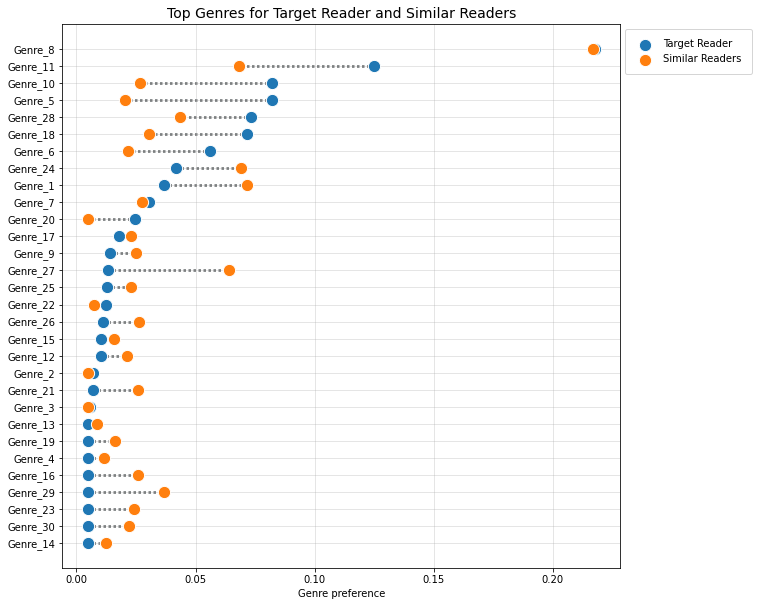

In [11]:
# Show top genres
plot_top_genres(neighbor_user_ratings, target_user_ratings)

In [12]:
# View most popular books among neighbors
neighbors_most_popular(neighbor_user_ratings, 15, min_ratings=400, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
49,The Hundred Thousand Kingdoms (Inheritance Tri...,3.81,30194.0,2010,3.5%,https://www.goodreads.com/book/show/6437061-th...
36,Secrets of a Side Bitch 4,4.60,838.0,2015,1.8%,https://www.goodreads.com/book/show/24518739-s...
62,Topaz,4.59,875.0,1997,1.8%,https://www.goodreads.com/book/show/1371133.Topaz
35,Secrets of a Side Bitch 3,4.58,1181.0,2014,1.8%,https://www.goodreads.com/book/show/20934376-s...
34,Secrets of a Side Bitch 2,4.54,1419.0,2013,1.8%,https://www.goodreads.com/book/show/18781068-s...
54,The Simone Campbell Story: Secrets of a Side B...,4.54,449.0,2014,1.8%,https://www.goodreads.com/book/show/23882684-t...
64,War's Unwomanly Face,4.52,1182.0,1988,1.8%,https://www.goodreads.com/book/show/4025275-wa...
8,Assata: An Autobiography,4.47,11057.0,1999,1.8%,https://www.goodreads.com/book/show/100322.Assata
37,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,1.8%,https://www.goodreads.com/book/show/27220736-s...
7,Asking for It: The Alarming Rise of Rape Cultu...,4.39,1721.0,2015,1.8%,https://www.goodreads.com/book/show/17836520-a...


In [13]:
# View highest rated books among similar readers
neighbors_top_rated(neighbor_user_ratings, 15, min_ratings=400, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
36,Secrets of a Side Bitch 4,4.60,838.0,2015,https://www.goodreads.com/book/show/24518739-s...
62,Topaz,4.59,875.0,1997,https://www.goodreads.com/book/show/1371133.Topaz
35,Secrets of a Side Bitch 3,4.58,1181.0,2014,https://www.goodreads.com/book/show/20934376-s...
34,Secrets of a Side Bitch 2,4.54,1419.0,2013,https://www.goodreads.com/book/show/18781068-s...
54,The Simone Campbell Story: Secrets of a Side B...,4.54,449.0,2014,https://www.goodreads.com/book/show/23882684-t...
64,War's Unwomanly Face,4.52,1182.0,1988,https://www.goodreads.com/book/show/4025275-wa...
8,Assata: An Autobiography,4.47,11057.0,1999,https://www.goodreads.com/book/show/100322.Assata
37,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,https://www.goodreads.com/book/show/27220736-s...
7,Asking for It: The Alarming Rise of Rape Cultu...,4.39,1721.0,2015,https://www.goodreads.com/book/show/17836520-a...
25,My Journey : Transforming Dreams into Actions,4.35,1743.0,2013,https://www.goodreads.com/book/show/18371021-m...


In [14]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=neighbor_user_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=5, 
    min_score=3.9, 
    min_ratings=400, 
    n_recs=15,
    write_to_excel=False
)

Genre 8: ['people', 'world', 'way', 'question', 'offer', 'guide', 'history', 'science', 'human', 'experience']


,title,avg_rating,ratings_count,url
1,Asking for It: The Alarming Rise of Rape Cultu...,4.39,1721.0,https://www.goodreads.com/book/show/17836520-a...
0,"""I Give You My Body . . ."": How I Write Sex Sc...",4.21,481.0,https://www.goodreads.com/book/show/30719827-i...
13,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
6,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
4,Continuous Delivery: Reliable Software Release...,4.15,1748.0,https://www.goodreads.com/book/show/8686650-co...
24,The Purity Myth: How America's Obsession with ...,4.06,5741.0,https://www.goodreads.com/book/show/4914761-th...
25,Things No One Will Tell Fat Girls: A Handbook ...,4.06,1488.0,https://www.goodreads.com/book/show/24796533-t...
23,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,https://www.goodreads.com/book/show/10127019-t...
3,Capital in the Twenty-First Century,4.02,13494.0,https://www.goodreads.com/book/show/18736925-c...
20,Thank You for Being Late: An Optimist's Guide ...,3.96,3010.0,https://www.goodreads.com/book/show/26114127-t...


_____

Genre 11: ['history', 'war', 'century', 'account', 'historical', 'world', 'great', 'year', 'political', 'epic']


,title,avg_rating,ratings_count,url
8,War's Unwomanly Face,4.52,1182.0,https://www.goodreads.com/book/show/4025275-wa...
5,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,https://www.goodreads.com/book/show/23995249-t...
7,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
0,Dirt: The Erosion of Civilizations,3.94,736.0,https://www.goodreads.com/book/show/587916.Dirt
2,No One Cares About Crazy People: The Chaos and...,3.92,834.0,https://www.goodreads.com/book/show/30363776-n...
4,"The Clockwork Universe: Isaac Newton, the Roya...",3.91,3763.0,https://www.goodreads.com/book/show/9449985-th...


_____

Genre 10: ['alien', 'ship', 'planet', 'space', 'crew', 'human', 'world', 'galaxy', 'universe', 'sea']


,title,avg_rating,ratings_count,url
2,Rolling in the Deep (Rolling in the Deep #0.5),3.94,1569.0,https://www.goodreads.com/book/show/23634011-r...


_____

Genre 5: ['collection', 'classic', 'poem', 'fiction', 'text', 'introduction', 'includes', 'art', 'writing', 'short']


,title,avg_rating,ratings_count,url
1,Octavia's Brood: Science Fiction Stories from ...,3.94,1088.0,https://www.goodreads.com/book/show/23129839-o...


_____

Genre 28: ['family', 'young', 'world', 'year', 'faith', 'black', 'memoir', 'political', 'history', 'journey']


,title,avg_rating,ratings_count,url
0,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$R = U \Sigma \mathbf{V}^\top$$ where $U$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

-----

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of th math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

#### 2.1 - Factorize User-Rating Matrix with SVD

In [15]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
svd_neighborhood_ratings, target_user_ratings = find_neighbors(
                                                    1500, target, df_reviews_norm, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_15968/1780821165.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_15968/1780821165.py:64: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_15968/1780821165.py:65: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]


In [16]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"\nNeighborhood contains {svd_neighborhood_ratings.shape[0]} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]


Neighborhood contains 9507 books


In [17]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=5)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [18]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(
                all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

In [19]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:]

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index", "book_id"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [20]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4.15 & ratings_count > 750").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
5,"I, Robot (Robot #0.1)",4.17,0.421316,201196.0,2004,https://www.goodreads.com/book/show/41804.I_Robot
7,"The Pillars of the Earth (Kingsbridge, #1)",4.29,0.347621,471990.0,2002,https://www.goodreads.com/book/show/5043.The_P...
8,"Wool Omnibus (Silo, #1)",4.24,0.331137,83601.0,2012,https://www.goodreads.com/book/show/13453029-w...
13,The New Jim Crow: Mass Incarceration in the Ag...,4.49,0.243416,24694.0,2010,https://www.goodreads.com/book/show/6792458-th...
18,What It Takes: The Way to the White House,4.37,0.208968,1603.0,1992,https://www.goodreads.com/book/show/380057.Wha...
20,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,0.203923,225626.0,1996,https://www.goodreads.com/book/show/13.The_Ult...
22,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,0.199606,95353.0,1997,https://www.goodreads.com/book/show/5544.Surel...
24,Letter from the Birmingham Jail,4.64,0.190279,2776.0,1994,https://www.goodreads.com/book/show/203899.Let...
27,Shoe Dog: A Memoir by the Creator of NIKE,4.44,0.187860,27468.0,2016,https://www.goodreads.com/book/show/27220736-s...
32,Saga: Book One,4.70,0.164518,4201.0,2014,https://www.goodreads.com/book/show/22078240-saga


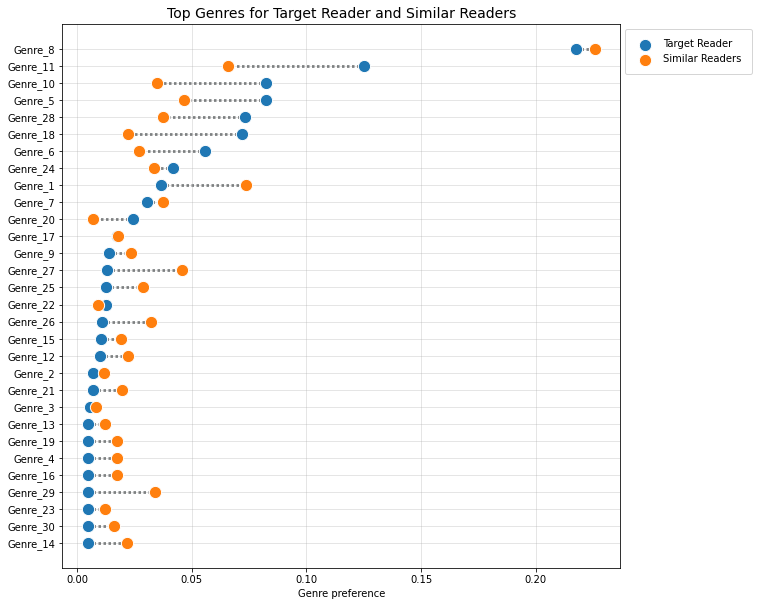

In [21]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [22]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, 50, min_ratings=400, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
2778,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,2002,1.7%,https://www.goodreads.com/book/show/5043.The_P...
1824,"Rich Dad, Poor Dad",3.96,164543.0,2007,1.6%,https://www.goodreads.com/book/show/69571.Rich...
294,Bad Feminist,3.91,43988.0,2014,1.6%,https://www.goodreads.com/book/show/18813642-b...
1941,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,1.3%,https://www.goodreads.com/book/show/27220736-s...
2479,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,1.3%,https://www.goodreads.com/book/show/15819028-t...
236,"Angels & Demons (Robert Langdon, #1)",3.86,2046499.0,2006,1.3%,https://www.goodreads.com/book/show/960.Angels...
3381,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,1.2%,https://www.goodreads.com/book/show/13453029-w...
2731,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,2010,1.0%,https://www.goodreads.com/book/show/6792458-th...
2085,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,1997,0.9%,https://www.goodreads.com/book/show/5544.Surel...
2536,The Hundred Thousand Kingdoms (Inheritance Tri...,3.81,30194.0,2010,0.8%,https://www.goodreads.com/book/show/6437061-th...


In [23]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, min_ratings=400, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
1170,Ignatius Catholic Study Bible: New Testament,4.78,527.0,2010,https://www.goodreads.com/book/show/6753273-ig...
1865,Saga: Book One,4.70,4201.0,2014,https://www.goodreads.com/book/show/22078240-saga
638,Dear Evan Hansen,4.70,563.0,2017,https://www.goodreads.com/book/show/34381137-d...
1866,Saga: Book Two,4.68,866.0,2017,https://www.goodreads.com/book/show/32926680-saga
61,A Game of Thrones: The Book of Ice and Fire RP...,4.67,7486.0,2004,https://www.goodreads.com/book/show/4700482-a-...
1134,I Dissent: Ruth Bader Ginsburg Makes Her Mark,4.67,1665.0,2016,https://www.goodreads.com/book/show/28210996-i...
1140,I Will Lead You Along: The Life of Henry B. Ey...,4.67,434.0,2013,https://www.goodreads.com/book/show/18781290-i...
2527,The Holy Bible: English Standard Version,4.66,18613.0,2007,https://www.goodreads.com/book/show/5883777-th...
2432,The Food Lab: Better Home Cooking Through Science,4.65,3005.0,2015,https://www.goodreads.com/book/show/24861842-t...
1320,Letter from the Birmingham Jail,4.64,2776.0,1994,https://www.goodreads.com/book/show/203899.Let...


In [24]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=5, 
    min_score=4.0, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=False
)

Genre 8: ['people', 'world', 'way', 'question', 'offer', 'guide', 'history', 'science', 'human', 'experience']


,title,avg_rating,ratings_count,url
16,Capital in the Twenty-First Century,4.02,13494.0,https://www.goodreads.com/book/show/18736925-c...
28,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,https://www.goodreads.com/book/show/10127019-t...
37,Islam and the Future of Tolerance: A Dialogue,4.11,3811.0,https://www.goodreads.com/book/show/25151238-i...
44,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0,https://www.goodreads.com/book/show/25744928-d...
51,Digital Gold: Bitcoin and the Inside Story of ...,4.16,1674.0,https://www.goodreads.com/book/show/23546676-d...
98,Anti-Intellectualism in American Life,4.18,1720.0,https://www.goodreads.com/book/show/582067.Ant...
72,Achieving Our Country: Leftist Thought in Twen...,4.11,593.0,https://www.goodreads.com/book/show/86103.Achi...
59,Nazi Germany and the Jews: The Years of Exterm...,4.21,934.0,https://www.goodreads.com/book/show/692474.Naz...
107,Why the West Rules—for Now: The Patterns of Hi...,4.09,2505.0,https://www.goodreads.com/book/show/9491855-wh...
114,"The Hidden Life of Trees: What They Feel, How ...",4.07,6030.0,https://www.goodreads.com/book/show/28256439-t...


_____

Genre 11: ['history', 'war', 'century', 'account', 'historical', 'world', 'great', 'year', 'political', 'epic']


,title,avg_rating,ratings_count,url
7,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,https://www.goodreads.com/book/show/5043.The_P...
42,"Lawrence in Arabia: War, Deceit, Imperial Foll...",4.12,7839.0,https://www.goodreads.com/book/show/17262206-l...
45,Che Guevara: A Revolutionary Life,4.10,13756.0,https://www.goodreads.com/book/show/10836.Che_...
46,KL: A History of the Nazi Concentration Camps,4.46,590.0,https://www.goodreads.com/book/show/22237143-kl
76,Lenin's Tomb: The Last Days of the Soviet Empire,4.18,2781.0,https://www.goodreads.com/book/show/113206.Len...
91,"The Prophet Armed: Trotsky, 1879-1921",4.30,638.0,https://www.goodreads.com/book/show/184654.The...
83,The Looming Tower: Al Qaeda and the Road to 9/11,4.38,1103.0,https://www.goodreads.com/book/show/525461.The...
78,George F. Kennan: An American Life,4.06,1318.0,https://www.goodreads.com/book/show/11910982-g...
77,"Stalin: Volume I: Paradoxes of Power, 1878-1928",4.24,513.0,https://www.goodreads.com/book/show/20821221-s...
75,Albert Speer: His Battle with Truth,4.25,1174.0,https://www.goodreads.com/book/show/402168.Alb...


_____

Genre 10: ['alien', 'ship', 'planet', 'space', 'crew', 'human', 'world', 'galaxy', 'universe', 'sea']


,title,avg_rating,ratings_count,url
5,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
20,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,225626.0,https://www.goodreads.com/book/show/13.The_Ult...
38,"I, Robot (Robot, #0.1)",4.17,2235.0,https://www.goodreads.com/book/show/76684.I_Robot
211,Heir to the Empire (Star Wars: The Thrawn Tril...,4.12,51211.0,https://www.goodreads.com/book/show/216443.Hei...
230,The Egg,4.13,10841.0,https://www.goodreads.com/book/show/17563539-t...
233,Pandora's Star,4.24,28964.0,https://www.goodreads.com/book/show/45252.Pand...
655,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
666,"Shards of Honour (Vorkosigan Saga, #1)",4.13,17172.0,https://www.goodreads.com/book/show/61903.Shar...
731,The Story of Earth: The First 4.5 Billion Year...,4.19,1072.0,https://www.goodreads.com/book/show/13483740-t...
898,The Hunt for Vulcan: . . . And How Albert Eins...,4.02,960.0,https://www.goodreads.com/book/show/25238350-t...


_____

Genre 5: ['collection', 'classic', 'poem', 'fiction', 'text', 'introduction', 'includes', 'art', 'writing', 'short']


,title,avg_rating,ratings_count,url
32,Saga: Book One,4.70,4201.0,https://www.goodreads.com/book/show/22078240-saga
80,The Great Terror: A Reassessment,4.10,628.0,https://www.goodreads.com/book/show/52137.The_...
113,Dragons of Eden: Speculations on the Evolution...,4.16,13576.0,https://www.goodreads.com/book/show/32276.Drag...
126,"Unweaving the Rainbow: Science, Delusion and t...",4.01,8226.0,https://www.goodreads.com/book/show/31487.Unwe...
189,The Essential Neruda: Selected Poems,4.46,4620.0,https://www.goodreads.com/book/show/5931.The_E...
156,Against Interpretation and Other Essays,4.11,4522.0,https://www.goodreads.com/book/show/52374.Agai...
212,Consider the Lobster and Other Essays,4.25,27237.0,https://www.goodreads.com/book/show/6751.Consi...
267,The Will to Power,4.04,7295.0,https://www.goodreads.com/book/show/31785.The_...
405,Russia: A 1000-Year Chronicle of the Wild East,4.07,555.0,https://www.goodreads.com/book/show/12377879-r...
430,A Game of Thrones: The Book of Ice and Fire RP...,4.67,7486.0,https://www.goodreads.com/book/show/4700482-a-...


_____

Genre 28: ['family', 'young', 'world', 'year', 'faith', 'black', 'memoir', 'political', 'history', 'journey']


,title,avg_rating,ratings_count,url
13,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,https://www.goodreads.com/book/show/6792458-th...
22,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
33,Seductive Poison: A Jonestown Survivor's Story...,4.05,1867.0,https://www.goodreads.com/book/show/345220.Sed...
147,Malcolm X: A Life of Reinvention,4.20,11929.0,https://www.goodreads.com/book/show/7940589-ma...
381,The Sisters Are Alright: Changing the Broken N...,4.19,644.0,https://www.goodreads.com/book/show/25092262-t...
427,Nine Parts of Desire: The Hidden World of Isla...,4.04,10469.0,https://www.goodreads.com/book/show/337615.Nin...
566,If Grace Is True: Why God Will Save Every Pers...,4.20,956.0,https://www.goodreads.com/book/show/111829.If_...
677,Rediscover Catholicism,4.18,1978.0,https://www.goodreads.com/book/show/10160346-r...
755,"The Autobiography of Martin Luther King, Jr.",4.32,11478.0,https://www.goodreads.com/book/show/42547.The_...
954,Narrative of Sojourner Truth,4.11,5906.0,https://www.goodreads.com/book/show/349076.Nar...


_____



### 2.3 Matrix Factorization with Gradient Descent

In [25]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
gd_neighborhoodhood_ratings, target_user_ratings = find_neighbors(
                                                        1500, target, df_reviews_norm, book_index, df_books)

# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"\nNeighborhood contains {gd_neighborhood_book_index.shape[0]} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_15968/1780821165.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_15968/1780821165.py:64: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_15968/1780821165.py:65: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]



Neighborhood contains 7606 books


In [26]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=5, steps=4000, lr=0.0002, beta=0.03, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient            

        # Calculate error every n steps                  
        if ((step + 1) % 1000 == 0) | (step == 0): 
            error = 0 # Initialize counter for error  
            error = error + np.sum(pow(resid, 2)) # Add to error
            for k in range(k_components): # for each component (latent feature)                             
                error = error + (beta/2) * np.sum(pow(P[i,k],2) + pow(Q[k,j],2)) # Add regularized term            

            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, error: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 2
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [27]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=50, 
                                    lr=0.009, 
                                    beta=0.07,
                                    decay=True, 
                                    steps=8000, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, error: 880756.64, lr: 0.00900
Step: 1000, error: 9720.37, lr: 0.00450
Step: 2000, error: 8372.66, lr: 0.00225
Step: 3000, error: 8084.71, lr: 0.00112
Step: 4000, error: 8003.21, lr: 0.00056
Step: 5000, error: 7975.11, lr: 0.00028
Step: 6000, error: 7963.92, lr: 0.00014
Step: 7000, error: 7959.00, lr: 0.00007
Step: 8000, error: 7956.70, lr: 0.00004


In [28]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_preds_GD[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4 & ratings_count > 400").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
0,The Philosophy Book,4.16,5.658357,1485.0,2011,https://www.goodreads.com/book/show/8493026-th...
1,Racing Hummingbirds,4.35,5.610672,469.0,2010,https://www.goodreads.com/book/show/7954894-ra...
4,Nazi Germany and the Jews: The Years of Persec...,4.10,5.509844,921.0,1998,https://www.goodreads.com/book/show/692473.Naz...
5,"The Prophet Armed: Trotsky, 1879-1921",4.30,5.384111,638.0,2004,https://www.goodreads.com/book/show/184654.The...
7,Achieving Our Country: Leftist Thought in Twen...,4.11,5.342806,593.0,1999,https://www.goodreads.com/book/show/86103.Achi...
11,Albert Speer: His Battle with Truth,4.25,5.314117,1174.0,1996,https://www.goodreads.com/book/show/402168.Alb...
12,Lenin's Tomb: The Last Days of the Soviet Empire,4.18,5.304605,2781.0,1994,https://www.goodreads.com/book/show/113206.Len...
21,The Harvest of Sorrow: Soviet Collectivization...,4.09,5.121361,477.0,1987,https://www.goodreads.com/book/show/52139.The_...
25,Reminiscences of a Stock Operator,4.16,5.095828,7916.0,1923,https://www.goodreads.com/book/show/100779.Rem...
28,The Prayer That Changes Everything: The Hidden...,4.50,5.066789,999.0,2005,https://www.goodreads.com/book/show/375836.The...


In [29]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.0, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=False
)

Genre 8: ['people', 'world', 'way', 'question', 'offer', 'guide', 'history', 'science', 'human', 'experience']


,title,avg_rating,ratings_count,url
0,The Philosophy Book,4.16,1485.0,https://www.goodreads.com/book/show/8493026-th...
7,Achieving Our Country: Leftist Thought in Twen...,4.11,593.0,https://www.goodreads.com/book/show/86103.Achi...
25,Reminiscences of a Stock Operator,4.16,7916.0,https://www.goodreads.com/book/show/100779.Rem...
30,Not a Fan: Becoming a Completely Committed Fol...,4.22,23451.0,https://www.goodreads.com/book/show/11198480-n...
31,Nazi Germany and the Jews: The Years of Exterm...,4.21,934.0,https://www.goodreads.com/book/show/692474.Naz...
43,6 Months to 6 Figures,4.07,915.0,https://www.goodreads.com/book/show/23702503-6...
70,Platform Revolution: How Networked Markets Are...,4.16,806.0,https://www.goodreads.com/book/show/25622861-p...
102,Anti-Intellectualism in American Life,4.18,1720.0,https://www.goodreads.com/book/show/582067.Ant...
116,See You at the Top,4.25,9153.0,https://www.goodreads.com/book/show/161415.See...
131,Every Body Yoga: Let Go of Fear. Get On the Ma...,4.34,619.0,https://www.goodreads.com/book/show/30754069-e...


_____

Genre 11: ['history', 'war', 'century', 'account', 'historical', 'world', 'great', 'year', 'political', 'epic']


,title,avg_rating,ratings_count,url
4,Nazi Germany and the Jews: The Years of Persec...,4.10,921.0,https://www.goodreads.com/book/show/692473.Naz...
5,"The Prophet Armed: Trotsky, 1879-1921",4.30,638.0,https://www.goodreads.com/book/show/184654.The...
11,Albert Speer: His Battle with Truth,4.25,1174.0,https://www.goodreads.com/book/show/402168.Alb...
12,Lenin's Tomb: The Last Days of the Soviet Empire,4.18,2781.0,https://www.goodreads.com/book/show/113206.Len...
21,The Harvest of Sorrow: Soviet Collectivization...,4.09,477.0,https://www.goodreads.com/book/show/52139.The_...
35,No Name in the Street,4.37,805.0,https://www.goodreads.com/book/show/256105.No_...
38,George F. Kennan: An American Life,4.06,1318.0,https://www.goodreads.com/book/show/11910982-g...
84,The German War: A Nation Under Arms,4.29,541.0,https://www.goodreads.com/book/show/14894647-t...
91,The Looming Tower: Al Qaeda and the Road to 9/11,4.38,1103.0,https://www.goodreads.com/book/show/525461.The...
126,War's Unwomanly Face,4.52,1182.0,https://www.goodreads.com/book/show/4025275-wa...


_____

Genre 10: ['alien', 'ship', 'planet', 'space', 'crew', 'human', 'world', 'galaxy', 'universe', 'sea']


,title,avg_rating,ratings_count,url
129,Miracle in the Andes,4.22,11354.0,https://www.goodreads.com/book/show/454236.Mir...
235,"Master and Commander (Aubrey & Maturin, #1)",4.11,31858.0,https://www.goodreads.com/book/show/77430.Mast...
437,Atlas of Remote Islands,4.24,1807.0,https://www.goodreads.com/book/show/8197735-at...
623,"Rosie Revere, Engineer",4.54,4789.0,https://www.goodreads.com/book/show/17290220-r...
774,Leaves on the Wind,4.26,3704.0,https://www.goodreads.com/book/show/21532236-l...
1053,"Ghosts of the Tristan Basin (Powder Mage, #0.8)",4.34,584.0,https://www.goodreads.com/book/show/28825810-g...
1111,Enemy Mine,4.14,675.0,https://www.goodreads.com/book/show/1534509.En...
1135,"Deep: Freediving, Renegade Science, and What t...",4.40,1144.0,https://www.goodreads.com/book/show/18222705-deep
1442,"Linesman (Linesman, #1)",4.06,1130.0,https://www.goodreads.com/book/show/23604332-l...
1602,A Night Without Stars,4.41,1342.0,https://www.goodreads.com/book/show/28439513-a...


_____

Genre 5: ['collection', 'classic', 'poem', 'fiction', 'text', 'introduction', 'includes', 'art', 'writing', 'short']


,title,avg_rating,ratings_count,url
80,The Great Terror: A Reassessment,4.10,628.0,https://www.goodreads.com/book/show/52137.The_...
108,Sonny's Blues,4.22,3596.0,https://www.goodreads.com/book/show/157455.Son...
192,The Complete Clive Barker's The Great And Secr...,4.21,15868.0,https://www.goodreads.com/book/show/34871.The_...
210,"Complete Poems, 1904-1962",4.35,18787.0,https://www.goodreads.com/book/show/26596.Comp...
217,The Fire This Time: A New Generation Speaks ab...,4.35,2309.0,https://www.goodreads.com/book/show/28505023-t...
230,Horoscopes for the Dead,4.04,3064.0,https://www.goodreads.com/book/show/9315496-ho...
263,The Art of Language Invention: From Horse-Lord...,4.05,581.0,https://www.goodreads.com/book/show/24611649-t...
307,The Night Train at Deoli and Other Stories,4.14,2873.0,https://www.goodreads.com/book/show/475173.The...
331,Against Interpretation and Other Essays,4.11,4522.0,https://www.goodreads.com/book/show/52374.Agai...
337,Five Seasons: A Baseball Companion,4.33,474.0,https://www.goodreads.com/book/show/313298.Fiv...


_____

Genre 28: ['family', 'young', 'world', 'year', 'faith', 'black', 'memoir', 'political', 'history', 'journey']


,title,avg_rating,ratings_count,url
101,There are No Children Here: The Story of Two B...,4.25,10474.0,https://www.goodreads.com/book/show/41918.Ther...
182,Malcolm X: A Life of Reinvention,4.20,11929.0,https://www.goodreads.com/book/show/7940589-ma...
272,Everything That Rises Must Converge: Stories,4.27,14726.0,https://www.goodreads.com/book/show/218659.Eve...
332,"At the Existentialist Café: Freedom, Being, an...",4.22,2298.0,https://www.goodreads.com/book/show/25658482-a...
341,"Gunslinger: The Remarkable, Improbable, Iconic...",4.15,444.0,https://www.goodreads.com/book/show/28114395-g...
369,From #blacklivesmatter To Black Liberation,4.54,548.0,https://www.goodreads.com/book/show/25330220-f...
431,Nine Parts of Desire: The Hidden World of Isla...,4.04,10469.0,https://www.goodreads.com/book/show/337615.Nin...
497,Madam Secretary: A Memoir,4.05,5581.0,https://www.goodreads.com/book/show/674181.Mad...
500,Unashamed,4.45,1747.0,https://www.goodreads.com/book/show/25802615-u...
581,The Memory of Old Jack,4.26,1609.0,https://www.goodreads.com/book/show/227274.The...


_____

Genre 18: ['world', 'zombie', 'human', 'survivor', 'virus', 'city', 'plague', 'humanity', 'survive', 'war']


,title,avg_rating,ratings_count,url
502,A Rage for Revenge,4.05,913.0,https://www.goodreads.com/book/show/821436.A_R...
542,The Death and Life of the Great Lakes,4.44,573.0,https://www.goodreads.com/book/show/30231729-t...
641,The Hyperion Omnibus: Hyperion / The Fall of H...,4.41,2254.0,https://www.goodreads.com/book/show/3943.The_H...
651,"Indonesia, Etc.: Exploring the Improbable Nation",4.18,470.0,https://www.goodreads.com/book/show/18377963-i...
953,There Will Come Soft Rains,4.23,2554.0,https://www.goodreads.com/book/show/2260460.Th...
1049,On Palestine,4.10,430.0,https://www.goodreads.com/book/show/23129811-o...
1061,Ebola: The Natural and Human History of a Dead...,4.15,573.0,https://www.goodreads.com/book/show/23316552-e...
1071,Foundation / Foundation and Empire / Second Fo...,4.35,3316.0,https://www.goodreads.com/book/show/278097.Fou...
1190,"The Walking Dead, Compendium 3",4.62,4378.0,https://www.goodreads.com/book/show/25536846-t...
1231,Prelude to Foundation,4.05,41694.0,https://www.goodreads.com/book/show/30013.Prel...


_____

Genre 6: ['agent', 'mission', 'team', 'secret', 'terrorist', 'world', 'dangerous', 'enemy', 'government', 'spy']


,title,avg_rating,ratings_count,url
90,The Spy's Son: The True Story of the Highest-R...,4.02,464.0,https://www.goodreads.com/book/show/23168305-t...
163,"The Hunter (Victor the Assassin, #1)",4.13,2718.0,https://www.goodreads.com/book/show/10287666-t...
474,The Force,4.14,3620.0,https://www.goodreads.com/book/show/32075859-t...
501,"American Tabloid (Underworld USA, #1)",4.21,10342.0,https://www.goodreads.com/book/show/36064.Amer...
725,Chasing the Scream: The First and Last Days of...,4.49,5296.0,https://www.goodreads.com/book/show/22245552-c...
833,Ahsoka,4.02,798.0,https://www.goodreads.com/book/show/29468031-a...
884,How to Fight Presidents: Defending Yourself Ag...,4.12,1391.0,https://www.goodreads.com/book/show/17857647-h...
998,The Private Eye #1,4.24,512.0,https://www.goodreads.com/book/show/17662660-t...
1097,The Triple Agent: The al-Qaeda Mole who Infilt...,4.05,1906.0,https://www.goodreads.com/book/show/9945237-th...
1263,"The Man Who Never Missed (Matador, #1)",4.24,1423.0,https://www.goodreads.com/book/show/20878.The_...


_____

Genre 24: ['world', 'power', 'war', 'enemy', 'battle', 'magic', 'dragon', 'land', 'kingdom', 'warrior']


,title,avg_rating,ratings_count,url
160,When Christ and His Saints Slept (Henry II an...,4.27,10892.0,https://www.goodreads.com/book/show/43841.When...
170,Perfect State,4.07,8253.0,https://www.goodreads.com/book/show/25188109-p...
178,"The Potato Factory (The Potato Factory, #1)",4.07,6773.0,https://www.goodreads.com/book/show/137808.The...
300,"Beyond Redemption (Manifest Delusions, #1)",4.03,731.0,https://www.goodreads.com/book/show/23287202-b...
302,"Promise of Blood (Powder Mage, #1)",4.16,22179.0,https://www.goodreads.com/book/show/15790883-p...
383,Blackwing (Ravens' Mark #1),4.24,401.0,https://www.goodreads.com/book/show/33916060-b...
387,"Sins of Empire (Gods of Blood and Powder, #1)",4.48,2567.0,https://www.goodreads.com/book/show/28811016-s...
443,The Beast's Garden,4.03,822.0,https://www.goodreads.com/book/show/23702432-t...
626,"The Summer Dragon (The Evertide, #1)",4.05,1262.0,https://www.goodreads.com/book/show/26068046-t...
659,"Red Sister (Book of the Ancestor, #1)",4.32,5784.0,https://www.goodreads.com/book/show/25895524-r...


_____

Genre 1: ['family', 'world', 'young', 'time', 'year', 'voice', 'collection', 'child', 'human', 'moving']


,title,avg_rating,ratings_count,url
1,Racing Hummingbirds,4.35,469.0,https://www.goodreads.com/book/show/7954894-ra...
73,The Peregrine,4.18,1040.0,https://www.goodreads.com/book/show/1071726.Th...
92,This is the Story of a Happy Marriage,4.03,13538.0,https://www.goodreads.com/book/show/17349222-t...
187,"Notes from Underground, White Nights, The Drea...",4.17,66680.0,https://www.goodreads.com/book/show/17876.Note...
194,Manto: Selected Stories,4.13,543.0,https://www.goodreads.com/book/show/7518598-manto
207,Earth Is Room Enough,4.04,7772.0,https://www.goodreads.com/book/show/245645.Ear...
374,The Shining / Salems Lot / Night Shift / Carrie,4.64,1400.0,https://www.goodreads.com/book/show/5416.The_S...
382,The Almost Sisters,4.07,4155.0,https://www.goodreads.com/book/show/32600726-t...
405,Buffering: Unshared Tales of a Life Fully Loaded,4.27,712.0,https://www.goodreads.com/book/show/28218973-b...
415,High Tide in Tucson,4.03,8324.0,https://www.goodreads.com/book/show/14256.High...


_____

Genre 7: ['music', 'film', 'movie', 'star', 'rock', 'band', 'fan', 'actor', 'television', 'career']


,title,avg_rating,ratings_count,url
99,Come As You Are: The Story of Nirvana,4.03,6859.0,https://www.goodreads.com/book/show/104961.Com...
175,"I, Partridge: We Need to Talk About Alan",4.19,4856.0,https://www.goodreads.com/book/show/12363948-i...
180,Peter and Alice,4.44,561.0,https://www.goodreads.com/book/show/17347724-p...
285,Poorly Made in China: An Insider's Account of ...,4.04,1138.0,https://www.goodreads.com/book/show/5116296-po...
514,Room Full of Mirrors: A Biography of Jimi Hendrix,4.13,6265.0,https://www.goodreads.com/book/show/101636.Roo...
620,Crazy Is My Superpower: How I Triumphed by Br...,4.48,551.0,https://www.goodreads.com/book/show/27866300-c...
802,Spoiler Alert: The Hero Dies,4.08,1009.0,https://www.goodreads.com/book/show/32913135-s...
904,Moscow to the End of the Line,4.05,4673.0,https://www.goodreads.com/book/show/117896.Mos...
915,Out on the Wire: Uncovering the Secrets of Rad...,4.19,627.0,https://www.goodreads.com/book/show/23742836-o...
941,A Work in Progress,4.35,14878.0,https://www.goodreads.com/book/show/22886113-a...


_____

